# Bitcoin as a Diversifier to US Equity

## Introduction

This exercise will explore the potential diversification benefits of Bitcoin to an all-US equity portfolio. This will be done by examing two core metrics: correlation and Sharpe ratio. 

Correlations are drawn during market sell-off periods as well as normal market periods. The purpose for this comparison is to find out if Bitcoin is a good diversifier to US equities when it's needed the most, which is when the US equity market sells off.  

The Sharpe ratios of Bitcoin, the S&P 500, the NASDAQ, and equally balanced portfolios of BTC-SP500 and BTC-NASDAQ are compared. The Sharpe ratio will help determine the diversification benefit of Bitcoin to US equity.

## Assumptions

A sell-off market environment is defined as any daily returns that fall below the -2 standard deviation of SP500 daily price return.  

A normal market environment is defined as any daily returns that fall within the -2 standard deviation and +2 standard deviation of SP500 daily price return.

Data is filtered with sell off and normal market conditions

In [1]:
## 깃허브 : https://github.com/adamgulyas/diversifying-with-bitcoin
# 비트코인 탐색: 좋은 포트폴리오 다각화 장치인가요?
# 이 분석은 Bitcoin을 모든 미국 주식 포트폴리오에 대한 다각화 도구로 평가하는 것을 목표로 합니다.
# 비트코인을 미국 주식 포트폴리오에 대한 다각화 도구로 평가하는 것을 목표로 하는 데이터 분석.
#pip install yfinance
!pip install hvplot

In [2]:
# Initial imports
import panel as pn
pn.extension('plotly')
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import datetime
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

In [3]:
load_dotenv()

sb.set_style('darkgrid')

# Data Exploration and Cleanup

Using the `yfinance` library, price data was retreived through the Yahoo Finance API. Only necessary columns were kept and null values were dropped.

For data exploration, a +/-2 standard deviation for the S&P 500's daily return was calculated.  

In [4]:
# Download data from Yahoo API and clean data
today = datetime.date.today().isoformat()

response_yf = yf.download(
    "^GSPC ^IXIC BTC-USD", 
    start="2014-09-17", 
    end=today
)

# trimming the data
price_df = response_yf['Close']
price_df = price_df.rename(
    columns={
        '^GSPC': 'SP500', 
        '^IXIC': 'NASDAQ',
        'BTC-USD': 'BTC'
    }
).copy(deep=True)

# remove all NA 
price_df = price_df.dropna()

[*********************100%***********************]  3 of 3 completed


In [5]:
# Calculate daily price return for all assets.  Calculate the 2 standard deviation boundary for SP500

# calc daily percentage returns
pct_change_df = price_df.pct_change()
pct_change_df = pct_change_df.dropna()

pct_change_std = pct_change_df['SP500'].std()
pct_change_ret = pct_change_df['SP500'].mean()

# SP500 price return at 2 standard dev boundary
outlier_neg2std = pct_change_ret - pct_change_std * 2
outlier_pos2std = pct_change_ret + pct_change_std * 2

# Extract returns where S&P returns are below -2 std dev
pct_change_below_2std = pct_change_df.loc[
    pct_change_df['SP500'] <= outlier_neg2std
]
# Extract returns where S&P returns are within the 2 std dev
pct_change_inside_2std = pct_change_df.loc[
    (pct_change_df['SP500'] >= outlier_neg2std) & 
    (pct_change_df['SP500'] <= outlier_pos2std)
]

# Extract returns where S&P returns are greater the -2 std dev
pct_change_greater_2std = pct_change_df.loc[
    (pct_change_df['SP500'] > outlier_neg2std) 
]

# Create a portfolio between BTC & SP500, NASDAQ
combined_pct_change = pd.concat(
    [
        pct_change_df['BTC'] + pct_change_df['SP500'],
        pct_change_df['BTC'] + pct_change_df['NASDAQ']
    ],
    axis=1
)

# Extract returns where S&P returns are below -2 std dev
combined_pct_change_below_2std = combined_pct_change.loc[
    pct_change_df['SP500'] <= outlier_neg2std
]

# Extract returns where S&P returns are within the 2 std dev
combined_pct_change_inside_2std = combined_pct_change.loc[
    (pct_change_df['SP500'] >= outlier_neg2std) & 
    (pct_change_df['SP500'] <=outlier_pos2std)
]

# Extract returns where S&P returns are greater -2 std dev
combined_pct_change_greater_2std = combined_pct_change.loc[
    pct_change_df['SP500'] > outlier_neg2std
]

combined_pct_change.columns = ['BTC-SP500','BTC-NASDAQ']
combined_pct_change_below_2std.columns = ['BTC-SP500','BTC-NASDAQ']
combined_pct_change_inside_2std.columns = ['BTC-SP500','BTC-NASDAQ']
combined_pct_change_greater_2std.columns = ['BTC-SP500','BTC-NASDAQ']    

In [6]:
# Verify that portfolio returns are added correctly
pct_change_df['BTC'].iloc[0]+pct_change_df['SP500'].iloc[0]

-0.06703439592607463

In [7]:
combined_pct_change['BTC-SP500'].iloc[0] 

-0.06703439592607463

# Correlation & Beta Analysis

This section examines the correlation & beta between Bitcoin and the S&P 500 and NASDAQ in sell-off and normal market environments.


In [8]:
# Calculate correlation amongst all assets for returns that beyond the 2 std dev and within 2 std dev

# Correlation matrix
corr_below_2std = pct_change_below_2std.corr()
corr_inside_2std = pct_change_inside_2std.corr()
corr_greater_2std = pct_change_greater_2std.corr()


# Extract corr off the diagonal of the matrices
extracted_corr_below_2std = np.extract(
    1 - np.eye(len(corr_below_2std)), 
    corr_below_2std
)
extracted_corr_inside_2std  = np.extract(
    1 - np.eye(len(corr_below_2std)), 
    corr_inside_2std
)
extracted_corr_greater_2std  = np.extract(
    1 - np.eye(len(corr_below_2std)), 
    corr_greater_2std
)

# Retrieve only correlation btween BTC vs equity and SP500 vs NASDAQ
ix=[0,1,3]
extracted_corr_below_2std = [extracted_corr_below_2std[i] for i in ix]
extracted_corr_inside_2std = [extracted_corr_inside_2std[i] for i in ix]
extracted_corr_greater_2std = [extracted_corr_greater_2std[i] for i in ix]

In [9]:
# Calculate BTC beta to S&P and Nasdaq

# Covariance matrix
cov_below_2std = pct_change_below_2std.cov()
cov_greater_2std = pct_change_greater_2std.cov()


# Extract corr off the diagonal of the matrices
extracted_cov_below_2std = np.extract(
    1 - np.eye(len(cov_below_2std)), 
    cov_below_2std
)

extracted_cov_greater_2std = np.extract(
    1 - np.eye(len(cov_greater_2std)), 
    cov_greater_2std
)

# index location for pairwise of assets in the matrix
ix=[0,1,3]
extracted_cov_below_2std = [extracted_cov_below_2std[i] for i in ix]
extracted_cov_greater_2std = [extracted_cov_greater_2std[i] for i in ix]
# index location for variance
ix=[1,2,1]
extracted_var_below_2std = [cov_below_2std.iloc[i,i] for i in ix]
extracted_var_greater_2std = [cov_greater_2std.iloc[i,i] for i in ix]
# calculate beta
extracted_beta_below_2std = [i/j for i,j 
in zip(extracted_cov_below_2std,extracted_var_below_2std)]

extracted_beta_greater_2std = [i/j for i,j 
in zip(extracted_cov_greater_2std,extracted_var_greater_2std)]


## Charting Section

#### Charting functions

In [11]:
def create_dist_chart_fill_opt(data, xloc1, xloc2, annotate_txt):
    
    # xloc1 or xloc2 is the number on x-axis where the chart is shaded beyond that location
    # if both xloc1 and xloc2 are provided then a shaded area is in between those 2 numbers.
    # if both xloc1 and xloc2 are empty then no shading is done
    
    plt.figure(figsize=(12,5))
    ax = sb.distplot(data, hist=False)
    x, y = ax.get_lines()[0].get_data()
    line = ax.lines[0].get_data()

    if bool(xloc1) & bool(xloc2):
        plt.vlines(xloc1, 0, y[np.argmin(abs(x-xloc1))], color='k')
        plt.vlines(xloc2, 0, y[np.argmin(abs(x-xloc2))], color='k')
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])
        ax.fill_between(
            x, y, 
            where=(x>xloc1) & (x<xloc2), 
            interpolate=True,
            color='#EF9A9A'
        )      

    elif bool(xloc1) | bool(xloc2):
        plt.vlines(xloc1, 0, y[np.argmin(abs(x-xloc1))], color='k')
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])
        ax.fill_between(
            x, y, 
            where=(x < xloc1), 
            interpolate=True, 
            color='#EF9A9A'
        )

    else:    
        ax = sb.distplot(data)
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])  
        
    ax.set_title('Distribution of SP500 Daily Price Return')   
    ax.text(-0.12, 10,annotate_txt, fontsize=9)  

In [12]:
def create_bar_chart(data,title):
    plt.figure()
    barplot = data.hvplot.bar(title=title, height=300, width=500)
    return pn.pane.HoloViews(barplot, linked_axes=False)
    #return barplot

In [13]:
def create_bar_dropdown_chart(data,x,y,xlabel,ylabel,groupby,title):
    retminplot = data_ret_min.hvplot(kind='bar', x=x, y=y, xlabel=xlabel, ylabel=ylabel, groupby=groupby
    , rot=90, height=400,width=600, 
    title=title)
    return retminplot

### Chart density distribution charts

These charts highlight the section of the data distribution that will be used to calculate the correlation for sell-off and normal market environments.

The -2 standard deviation of the S&P 500's returns is highlighted on the chart.

C:\Users\user\AppData\Local\Temp\ipykernel_46060\567591237.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sb.distplot(data, hist=False)


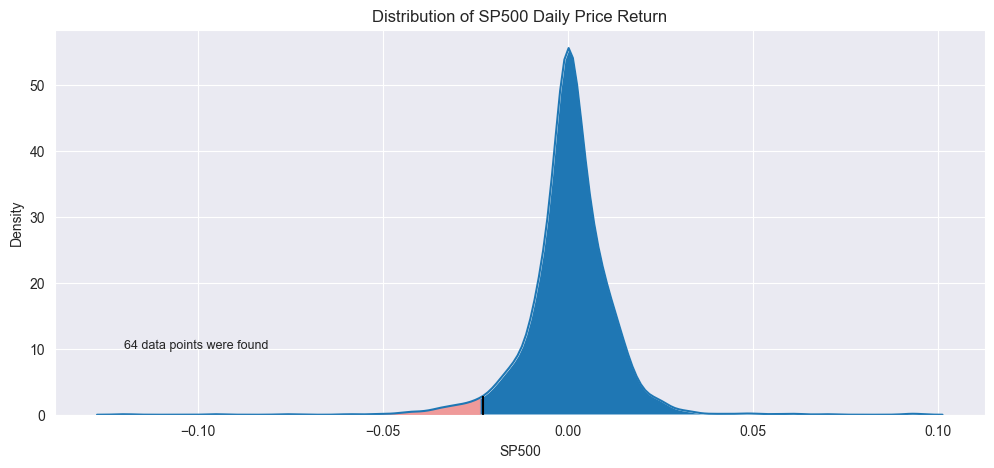

In [14]:
annotext = str(len(pct_change_below_2std)) + " data points were found"

selloff_dist_chart = create_dist_chart_fill_opt(
    pct_change_df['SP500'],
    outlier_neg2std,
    [],
    annotext
)

This chart highlights the normal trading activity greater than the -2 standard deviations.

C:\Users\user\AppData\Local\Temp\ipykernel_46060\567591237.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sb.distplot(data, hist=False)


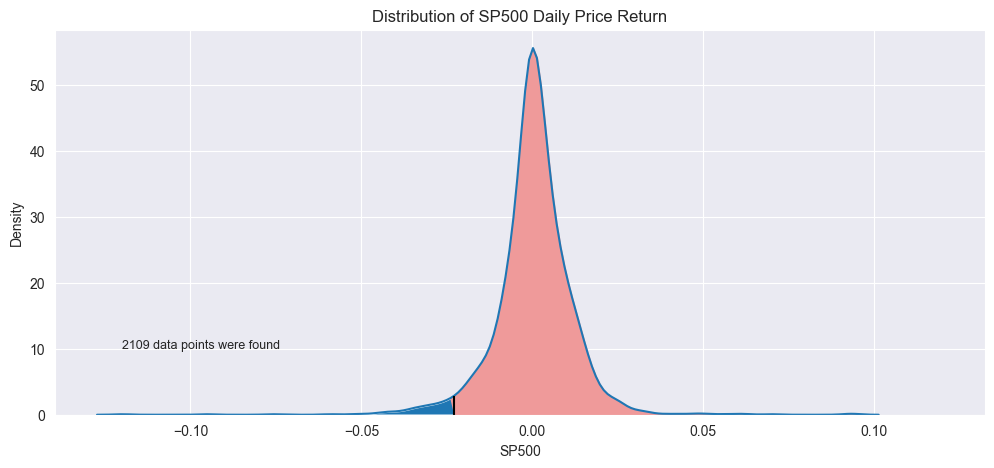

In [15]:
annotext = str(len(pct_change_inside_2std)) + " data points were found"

normal_dist_chart = create_dist_chart_fill_opt(
    pct_change_df['SP500'],
    outlier_neg2std,
    0.12,
    annotext
)

### Correlation & Beta results
The distinct difference between correlations and beta during sell-off and normal markets appears to suggest that Bitcoin is not a good diversifier to US equity. US Equity needs diversification the most during a market sell-off. 

The correlation between Bitcoin and equity spiked ~5x during market sell-offs. The correlation between the S&P 500 and NASDAQ remained high in both sell-off and normal market environments.

In [16]:
corr_btc_equity = pd.concat(
    [
        pd.DataFrame(extracted_corr_below_2std),
        pd.DataFrame(extracted_corr_greater_2std)
    ], 
    axis=1
)

corr_btc_equity = corr_btc_equity.set_index([
    pd.Index([
        'BTC vs SP500',
        'BTC vs NASDAQ',
        'SP500 vs NASDAQ'
    ])
])

corr_btc_equity.columns = ['selloff','normal']
corr_btc_equity

,selloff,normal
BTC vs SP500,0.481937,0.136193
BTC vs NASDAQ,0.498035,0.165610
SP500 vs NASDAQ,0.919664,0.932276


In [17]:
beta_btc_equity = pd.concat(
    [
        pd.DataFrame(extracted_beta_below_2std),
        pd.DataFrame(extracted_beta_greater_2std)
    ], 
    axis=1
)

beta_btc_equity = beta_btc_equity.set_index([
    pd.Index([
        'BTC vs SP500',
        'BTC vs NASDAQ',
        'SP500 vs NASDAQ'
    ])
])

beta_btc_equity.columns = ['selloff','normal']
beta_btc_equity

,selloff,normal
BTC vs SP500,2.387270,0.605818
BTC vs NASDAQ,2.482210,0.603981
SP500 vs NASDAQ,0.914034,1.137091


In [18]:
# Chart correlation for sell-off and normal markets

corr_selloff_chart = create_bar_chart(corr_btc_equity['selloff']
,"Correlation of BTC with SP500 and NASDAQ\n during sell-off market")
                                                      
corr_normal_chart = create_bar_chart(corr_btc_equity['normal'],
"Correlation of BTC with SP500 and NASDAQ\n during normal market ")     
                                                      
corr_chart = pn.Column(corr_selloff_chart,corr_normal_chart)                                                      

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
corr_chart

BokehModel(combine_events=True, render_bundle={'docs_json': {'f469d7a4-dec7-4bcf-bc64-b7ec4a934c70': {'version…

In [20]:
# Chart beta for sell-off and normal markets

beta_selloff_chart = create_bar_chart(beta_btc_equity['selloff'],
"Beta of BTC with SP500 and NASDAQ\n during sell-off market")
                                                      
beta_normal_chart = create_bar_chart(beta_btc_equity['normal'],
"Beta of BTC with SP500 and NASDAQ\n during normal market")    
                                                      
beta_chart = pn.Column(beta_selloff_chart,beta_normal_chart)  

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
beta_chart

BokehModel(combine_events=True, render_bundle={'docs_json': {'adc79095-a25b-4d8c-86bb-4b984ffc085e': {'version…

Text(0.5, 1.0, 'Correlation in a Normal Market Environment')

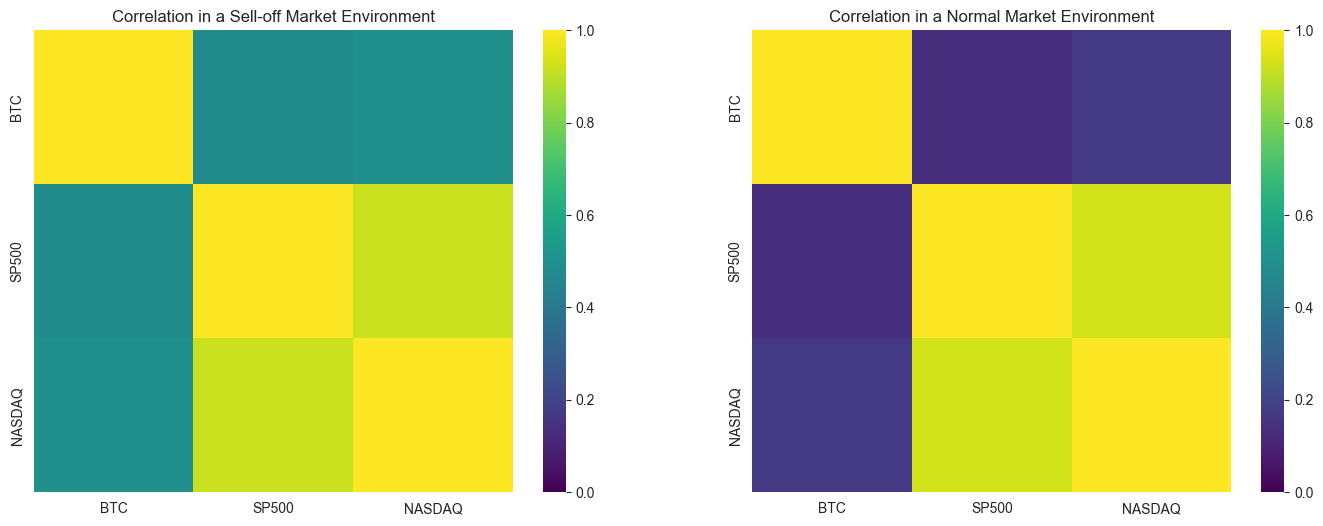

In [22]:
fig, ax = plt.subplots(1,2,figsize=(17,6))

selloff_mkt_heatmap = sb.heatmap(
    corr_below_2std, 
    vmin=0, 
    vmax=1,
    ax=ax[0],
    cmap='viridis'
)
normal_mkt_heatmap = sb.heatmap(
    corr_greater_2std, 
    vmin=0, 
    vmax=1,
    ax=ax[1],
    cmap='viridis'
)

selloff_mkt_heatmap.set_title(
    "Correlation in a Sell-off Market Environment"
)
normal_mkt_heatmap.set_title(
    "Correlation in a Normal Market Environment"
)

# Risk and Return Analysis 
This analysis examines the risk and return profile of each asset as well as equally weighted portfolios of BTC-SP500 and BTC-NASDAQ.

The first section of the analysis examined the return and the maximum loss of the assets and portfolios.

The second section of the analysis uses an alternative metric of Sharpe ratio to assess the return for every unit of risk of each assets and portfolio.

The third section of the analyis compares the annualized average daily return to the largest 1-day negative return.  The idea is to assess how one asset's ability to recover over the year given a largest 1 day loss.

Below are the visualized results of these analyses.

In [24]:
# Manipulate the time series data into data that can be used for return vs. max loss chart

# concatenate the BTC, SP, NASD returns with equally wgted portfolios
all_assets = pd.concat([pct_change_df, combined_pct_change], axis=1)
years = [2019, 2020, 2021, 2022]
data_ret_min = pd.DataFrame()
years_ret_min = pd.DataFrame()
year_df = pd.DataFrame()
# Loop through the last 4 years
for i in years:
    
    # Calculate the avg ret and min ret for each year
    yearly_data = all_assets[all_assets.index.year == i]
    yearly_avg = yearly_data.mean() * 252
    yearly_min = yearly_data.min()
    year_df = pd.DataFrame([i] * len(all_assets.columns)) 
    year_df = year_df.set_index(pd.Index(all_assets.columns))
    data_avg_min = pd.concat([yearly_avg, yearly_min], axis=1)
    data_avg_min = pd.concat([year_df, data_avg_min], axis=1)
    data_ret_min = data_ret_min.append(data_avg_min)
     
data_ret_min.columns = ['year','ann return', 'largest 1 day loss']
data_ret_min['port'] = data_ret_min.index

AttributeError: 'DataFrame' object has no attribute 'append'

In [25]:
ret_mxloss_chart = create_bar_dropdown_chart(data_ret_min,'year',['ann return','largest 1 day loss'],'Year','% return','port', 
"Compare Annualized Return to Largest 1-day Loss")

ret_mxloss_chart

ValueError: The supplied groupby dimension(s) ['port'] could not be found, expected one or more of: []

### Sharpe results

The Sharpe ratio for Bitcoin and the equally weighted portfolios outperformed both the S&P 500 and NASDAQ.

Despite high volatility of bitcoin and the portfolios, their returns compensated for every unit of risk superior to the S&P 500 and NASDAQ.

In [26]:
# annualized return, risk and sharpe for individual assets for whole history
all_pct_change = pd.concat([pct_change_df, combined_pct_change], axis=1)
annual_returns = all_pct_change.mean() * 252
annual_std = all_pct_change.std() * np.sqrt(252)
annual_sharpe = annual_returns / annual_std

# annualized return, risk and sharpe for individual assets for sell off market
all_pct_change_below_2std = pd.concat([pct_change_below_2std, combined_pct_change_below_2std], axis=1)
annual_returns_below_2std = all_pct_change_below_2std.mean() * 252
annual_std_below_2std = all_pct_change_below_2std.std() * np.sqrt(252)
annual_sharpe_below_2std = annual_returns_below_2std / annual_std_below_2std


In [27]:
# Create bar chart to display the annualized sharpe ratios for selloff and the whole history

sharpe_selloff_bar_chart = create_bar_chart(
    annual_sharpe_below_2std,
    'Annualized Sharpe Ratio for each assets and portfolios\n during sell off market'
)


#return pn.pane.HoloViews(fig, linked_axes=False)
sharpe_normal_bar_chart = create_bar_chart(
    annual_sharpe,
    'Annualized Sharpe Ratio for each assets and portfolios'
)

sharpe_bar_chart = pn.Column(sharpe_selloff_bar_chart,sharpe_normal_bar_chart)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
sharpe_bar_chart

BokehModel(combine_events=True, render_bundle={'docs_json': {'82c70538-f12e-4497-b558-1777f240bbbb': {'version…

In [30]:
plt.figure()
tabs = pn.Tabs(
    ("BTC - Equity Diversifier", sharpe_bar_chart),
    ("Correlation in diff Markets",corr_chart),
    ("Beta in diff Markets",beta_chart),
    ("Annualized return vs 1-day max loss",ret_mxloss_chart))
tabs

NameError: name 'ret_mxloss_chart' is not defined

<Figure size 640x480 with 0 Axes>